The goal is modeling a scenario in which a seller exploits advertising tools to attract more and more users to its website, thus increasing the number of possible buyers. The seller needs to learn simultaneously the conversion rate and the number of users the advertising tools can attract.

1) Imagine:
    - one product to sell;
    - three classes of users, where, for every user, we can observe the values of two binary features (feel free to choose the features and their domains);
    - the conversion rate curve of each class of users;
    - three subcampaigns, each with a different ad, to advertise the product, and each targeting a different class of users;
    - there are three abrupt phases;
    - for every abrupt phase and for every subcampaign, the probability distribution over the daily number of clicks for every value of budget allocated to that subcampaign.

3) Design a sliding-window combinatorial bandit algorithm for the case, instead, in which there are the three phases aforementioned.
Plot the cumulative regret and compare it with the cumulative regret that a non-sliding-window algorithm would obtain.


9 curve, 3 fasi

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project.Urbano08.AbruptBiddingEnvironment import AbruptBiddingEnvironment
from project.Urbano08.DynamicLearner import DynamicLearner
from project.Urbano08.TableAlgorithm import TableAlgorithm as Ta
import pandas as pd

In [2]:
n_phases = 3
len_window = 40
phaselen = 80
n_obs = 161 #3 abrupt phase
print_span = 40 #ogni quanti giorni printare i grafici

init_days = 20 #primi giorni si pullano gli arm in modo casuale senza pensare al reward massimo

n_subcamp = 3

max_bid = 1
max_clicks = 100
n_arms = 11

noise_std = 6.0

bids = np.linspace(0, max_bid, n_arms)

total_click_each_day  = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])


env = AbruptBiddingEnvironment(bids,max_clicks,noise_std,phaselen, n_phases)
learners = []

for i in range(0, n_subcamp):
    learners.append(DynamicLearner(n_arms,bids,len_window))

print(f'PHASES OF {env.phaselen} DAYS\nWINDOWS OF {len(learners[0].pulled_arms)} DAYS\n{n_obs} TOTAL OBSERVATION')

PHASES OF 80 DAYS
WINDOWS OF 0 DAYS
161 TOTAL OBSERVATION


DAY: 39
PULLED:[5, 3, 2]
CLICKS: [93.52259773 72.22366462 82.45901443]
TOT: 248.20527676823892

11
11
11
DAY: 79
PULLED:[5, 3, 2]
CLICKS: [97.22300933 71.8353446  98.91731673]
TOT: 267.9756706570428

11
11
11
DAY: 119
PULLED:[3, 4, 3]
CLICKS: [95.70184412 34.14157682 17.787382  ]
TOT: 147.6308029409484

11
11
11
DAY: 159
PULLED:[3, 4, 3]
CLICKS: [96.32548246 25.14124096 31.67754181]
TOT: 153.144265233916

11
11
11


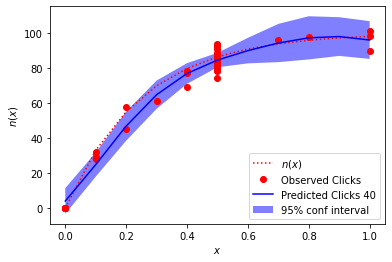

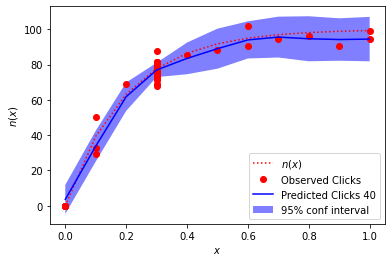

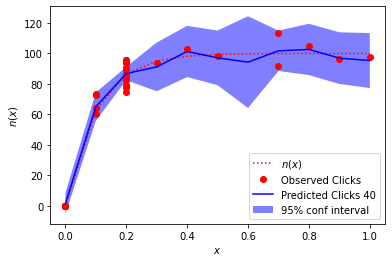

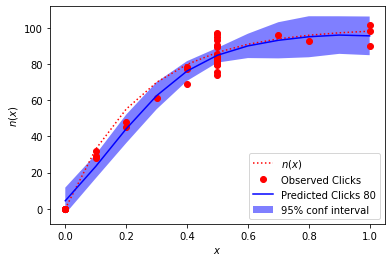

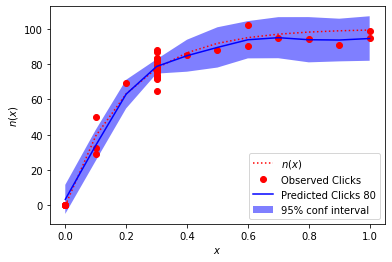

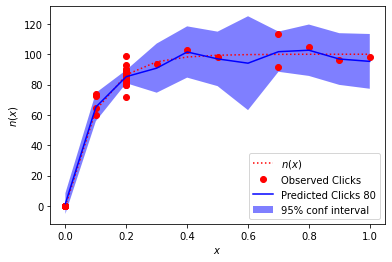

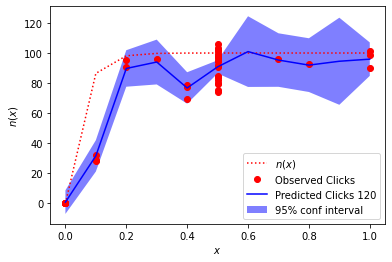

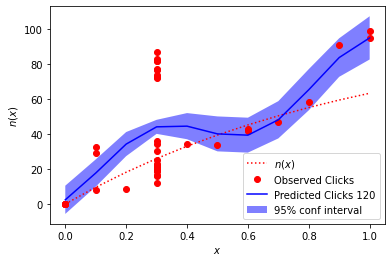

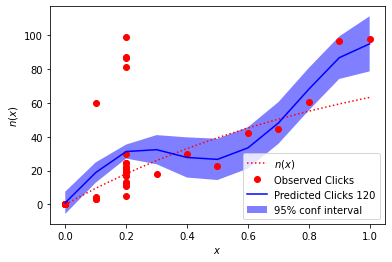

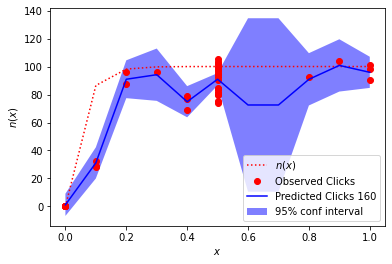

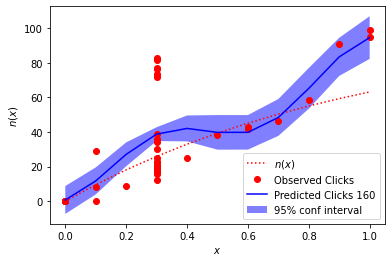

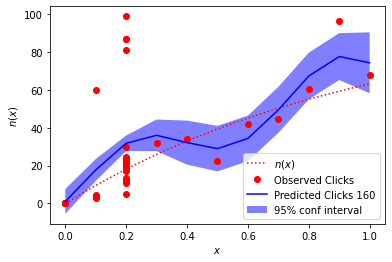

,bid_sub1,bid_sub2,bid_sub3,click1,click2,click3
0,0.0,3.0,7.0,0.000000,81.446723,91.834468
1,2.0,0.0,8.0,57.913891,0.000000,104.833210
2,7.0,3.0,0.0,96.076063,67.800566,0.000000
3,1.0,2.0,7.0,32.157601,69.144747,113.167081
4,0.0,10.0,0.0,0.000000,98.867502,0.000000
...,...,...,...,...,...,...
156,3.0,4.0,3.0,97.115389,26.663527,29.927847
157,3.0,4.0,3.0,102.975585,36.180719,24.808894
158,3.0,4.0,3.0,96.589609,24.686214,14.811877
159,3.0,4.0,3.0,96.325482,25.141241,31.677542


In [3]:
for d in range(0, n_obs):
    pulled = [0,0,0]
    #per i primi init_days giorni si pullano in modo causale, successivamente si usa la tabella
    if init_days > 0: #or d % int(len_window/2) == 0:
        init_days = init_days - 1
        first = d % 3
        pulled[first] = learners[first].pull_arm()
        pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
        pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1
    else:
        #uso l'algoritmo della tabella per selezionare gli arm che mi danno un reward massimo
        table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
        for l in learners:
            table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)
        pulled = Ta.fit_table(table_all_Subs)[0]


    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    if (d+1) % print_span == 0:
        #TIME TO PRINT THE PLOTS
        print(f"DAY: {d}\nPULLED:{pulled}\nCLICKS: {clicks}\nTOT: {clicks.sum()}\n")

        for l in range(0,len(learners)):
            learners[l].plot(env.subs[l])
            #X = np.atleast_2d(x_obs[:,i]).T
            #Y = y_obs[:,i].ravel()

            #plt.figure()

            #plt.plot(x_pred, env.subs[i](x_pred), 'r:', label=r'$n(x)$')
            #plt.plot(X.ravel(), Y, 'ro', label=r'Observed Clicks')
            #plt.plot(x_pred, learners[i].means, 'b-', label=r'Predicted Clicks')
            #plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
             #    np.concatenate([learners[i].means - 1.96 * learners[i].sigmas, (learners[i].means + 1.96 * learners[i].sigmas)[::-1]]),
             #    alpha=.5, fc='b', ec='None', label='95% conf interval')
            #plt.xlabel('$x$')
            #plt.ylabel('$n(x)$')
            #plt.legend(loc='lower right')
            #plt.show()
total_click_each_day



